In [1]:
# set cwd and solver
import os
import cobra
cobra.Configuration().solver = "gurobi"
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

In [2]:
# load all models in \cs_mods\July2023 folder by cycling through names
from cobra.io import read_sbml_model    
from pathlib import Path
import pandas as pd

# do not change directory but still go to the folder with the models
folder = Path().cwd() / "cs_mods" / "July2023"
model_list = []
for file in folder.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file.stem # remove .xml 
    model.name = file.stem # remove .xml
    model_list.append(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


In [3]:
# load old combined RPE_PR models
mod_RPE_PR = read_sbml_model(Path().cwd() / "models" / "mod_RPE_PR.xml")
mod_RPE_PR.id = 'RPE_PR_old'
mod_RPE_PR.name = 'RPE_PR_old'
mod_Human1_Human1 = read_sbml_model(Path().cwd() / "models" /  "mod_Human1_Human1.xml")
mod_Human1_Human1.id = 'RPE_PR_control_old'
mod_Human1_Human1.name = 'RPE_PR_control_old'
mod = read_sbml_model(Path().cwd() / 'models/Human-GEM.xml')
mod.id = 'Human1_old'
mod.name = 'Human1_old'

# add old models to model_list
model_list = model_list + [mod,mod_RPE_PR]

# check out model_list
model_list

[<Model Human-GEM_28062023 at 0x256756f9f00>,
 <Model mod_RPE_PRcone_Liang at 0x2567e3b4910>,
 <Model mod_RPE_PRcone_Liang_singlePR at 0x2564899e470>,
 <Model mod_RPE_PRcone_Liang_singleRPE at 0x2564a6b8eb0>,
 <Model mod_RPE_PRcone_Lukowski at 0x25657fd1f30>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x2565ce217e0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x25666e7bdf0>,
 <Model mod_RPE_PRcontrol at 0x25683071060>,
 <Model mod_RPE_PRrod_Liang at 0x256625f1ea0>,
 <Model mod_RPE_PRrod_Liang_singlePR at 0x256e0347220>,
 <Model mod_RPE_PRrod_Liang_singleRPE at 0x256e252fdf0>,
 <Model mod_RPE_PRrod_Lukowski at 0x256e75e70a0>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x25698e05db0>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x256f208ec80>,
 <Model Human1_old at 0x2570f095360>,
 <Model RPE_PR_old at 0x256756fa500>]

In [4]:
# modify models
# load blood exchange bounds

# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)
for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id and 'Human' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]
Human1_models = [m for m in model_list if 'Human' in m.id]

# close PR exchange in combined models and open RPE exchange (efflux)
for m in combined_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,0)
    for r in [r for r in m.reactions if len(r.products) == 0 if '_RPE' in r.id]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000) 

# only allow efflux exchange in single models
for m in single_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,1000)

# for Human1 models, open efflux
for m in [m for m in model_list if 'Human' in m.id]:
    for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000)

In [5]:
# set exchange bounds for blood
from src.modify_model import set_exchange_bounds
ex_bounds = {'MAR09048':(-3.51,1000),'MAR09034':(-4.18,1000),'MAR09135':(7.25,1000)}
# MAR09048: oxygen
# MAR09034: glucose
# MAR09135: lactate

results_dict = {}
for m in model_list:
    set_exchange_bounds(m, ex_bounds)
    m.optimize()
    results_dict[m.id] = m.objective.value
df1 = pd.DataFrame(results_dict, index = ['max ATP hydrolysis (pmol/s/mm^2)']).T
df1

,max ATP hydrolysis (pmol/s/mm^2)
Human-GEM_28062023,24.7325
mod_RPE_PRcone_Liang,23.9000
mod_RPE_PRcone_Liang_singlePR,11.1350
mod_RPE_PRcone_Liang_singleRPE,23.9000
mod_RPE_PRcone_Lukowski,24.7325
mod_RPE_PRcone_Lukowski_singlePR,22.2350
mod_RPE_PRcone_Lukowski_singleRPE,23.9000
mod_RPE_PRcontrol,24.7325
mod_RPE_PRrod_Liang,23.9000
mod_RPE_PRrod_Liang_singlePR,13.9100


In [6]:
model_list[-5]

Name,mod_RPE_PRrod_Lukowski
Memory address,256e75e70a0
Number of metabolites,10678
Number of reactions,14592
Number of genes,2188
Number of groups,149
Objective expression,1.0*MAR03964_PR - 1.0*MAR03964_PR_reverse_e8402
Compartments,"c_RPE, r_RPE, e_RPE, m_RPE, x_RPE, g_RPE, l_RPE, n_RPE, i_RPE, e_RPE_PR, c_PR, x_PR, m_PR, g_PR, r_PR, l_PR, i_PR"


In [16]:

##############################################
########         FBA heatmaps     ############
##############################################

from src.modify_model import create_permutation_dicts

from src.modify_model import create_permutation_dicts
# create a function to create stepwise tuple lists like the ones above
def create_stepwise_tuples(start,stop,step):
        """
        this function creates a list of tuples with the same start and stop values, but with a stepwise increase in the values

        Parameters
        ----------
        start : float
                start value
        stop : float
                stop value
        step : float
                step size

        Returns
        -------
        list
                list of tuples with the same start and stop values, but with a stepwise increase in the values

        """
        import numpy as np
        return [(i,i) for i in np.arange(start,stop+step,step)]

# test the function
bounds_oxygen = create_stepwise_tuples(-8,1,0.5)
bounds_lactate = create_stepwise_tuples(-4,10,0.5)
ex_bounds = {'MAR09048':[(-4.18,-4.18)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(-4.18,-4.18)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

In [22]:
# select model for heatmaps
model = model_list[-5]
model

# select model for heatmaps
model = model_list[-3]

In [23]:
# write function to do analysis for heatmaps
bounds_oxygen = create_stepwise_tuples(-8,1,2)
bounds_lactate = create_stepwise_tuples(-4,10,2)
ex_bounds = {'MAR09048':[(-4.18,-4.18)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(-4.18,-4.18)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)


def make_heatmap(model,bounds,labels):

    objective_values = []
    fluxes = []
    for i in range(len(bounds)):
        model = set_exchange_bounds(model,bounds[i])
        fba = model.optimize()
        fluxes.append(fba.fluxes)
        objective_values.append(fba.objective_value)

    objective_values_df = pd.DataFrame(objective_values)
    fluxes_df = pd.DataFrame(fluxes)
    objective_values_df['labels'] = labels # add labels


    ######### process data for heatmap #########

    b_df = pd.DataFrame()
    # create list of b
    for i in range(len(objective_values_df)):
        b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
        b_df = pd.concat([b_df,b],axis=0)

    b_df.reset_index(inplace=True,drop=True)
    df = pd.concat([b_df,objective_values_df],axis=1)
    # rename col 0 to objective_value
    df.rename(columns={0:'objective_value'},inplace=True)
    # select columns for heathmap (oxygen, lactate, and objective_value)
    df2 = df[['oxygen', 'lactate', 'objective_value']]

    #### reshape data and make heatmap ####

    df_reshaped = df2.pivot_table(index='oxygen', columns='lactate', values='objective_value')
    df_reshaped
    # heatmap

    fig, ax = plt.subplots(figsize=(13,4))
    sns.heatmap(df_reshaped, annot=False, fmt='.0f', cmap='rocket', annot_kws={"size": 10})
    plt.title('ATP yield')
    plt.xlabel('lactate uptake')
    plt.ylabel('oxygen uptake')
    # make boxes square
    plt.gca().set_aspect('equal', adjustable='box')
    #  annotation font size
    plt.tick_params(labelsize=12)
    # size bar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    plt.show()
    return 

c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

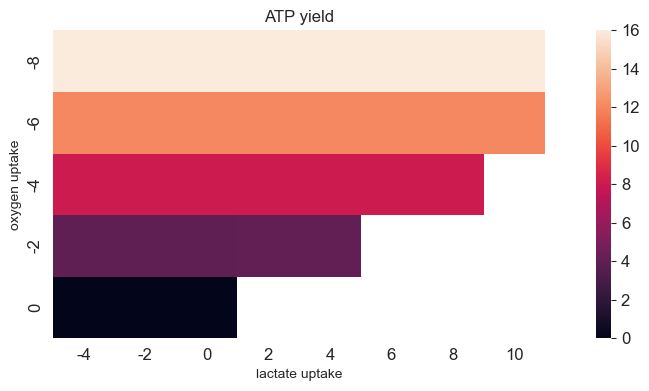

In [24]:
############### NO GLUCOSE  ###############

# write function to do analysis for heatmaps
bounds_oxygen = create_stepwise_tuples(-8,1,2)
bounds_lactate = create_stepwise_tuples(-4,10,2)
ex_bounds = {'MAR09048':[(-0,-0)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(0,0)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

make_heatmap(model,bounds,labels)

c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

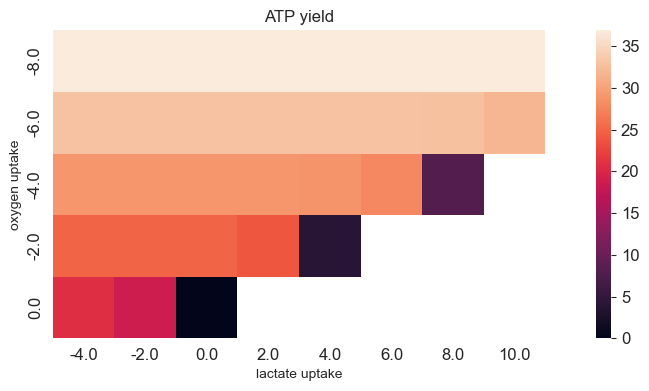

In [25]:
############### 4.18 GLUCOSE  ###############

# write function to do analysis for heatmaps
bounds_oxygen = create_stepwise_tuples(-8,1,2)
bounds_lactate = create_stepwise_tuples(-4,10,2)
ex_bounds = {'MAR09048':[(-4.18,-4.18)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(-4.18,-4.18)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

make_heatmap(model,bounds,labels)

c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

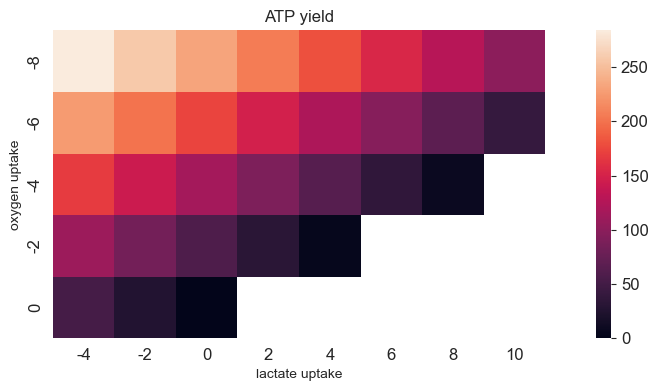

In [26]:
############### 1000 GLUCOSE  ###############

# write function to do analysis for heatmaps
bounds_oxygen = create_stepwise_tuples(-8,1,2)
bounds_lactate = create_stepwise_tuples(-4,10,2)
ex_bounds = {'MAR09048':[(-1000,-1000)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(-1000,-1000)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

make_heatmap(model,bounds,labels)

c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

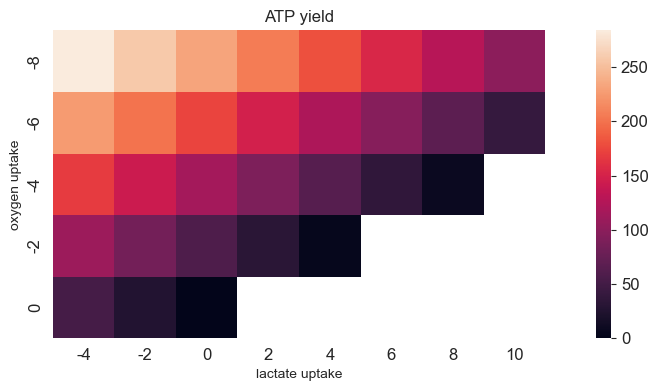

In [27]:
    # write function to do analysis for heatmaps
    bounds_oxygen = create_stepwise_tuples(-8,1,2)
    bounds_lactate = create_stepwise_tuples(-4,10,2)
    ex_bounds = {'MAR09048':[(-1000,-1000)],\
            'MAR09034':bounds_oxygen,\
            'MAR09135':bounds_lactate}

    ex_labels = {'glucose':[(-1000,-1000)],\
            'oxygen':bounds_oxygen,\
            'lactate':bounds_lactate}

    bounds = create_permutation_dicts(ex_bounds)
    labels = create_permutation_dicts(ex_labels)

    objective_values = []
    fluxes = []
    for i in range(len(bounds)):
        model = set_exchange_bounds(model,bounds[i])
        fba = model.optimize()
        fluxes.append(fba.fluxes)
        objective_values.append(fba.objective_value)

    objective_values_df = pd.DataFrame(objective_values)
    fluxes_df = pd.DataFrame(fluxes)
    objective_values_df['labels'] = labels # add labels


    ######### process data for heatmap #########

    b_df = pd.DataFrame()
    # create list of b
    for i in range(len(objective_values_df)):
        b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
        b_df = pd.concat([b_df,b],axis=0)

    b_df.reset_index(inplace=True,drop=True)
    df = pd.concat([b_df,objective_values_df],axis=1)
    # rename col 0 to objective_value
    df.rename(columns={0:'objective_value'},inplace=True)
    # select columns for heathmap (oxygen, lactate, and objective_value)
    df2 = df[['oxygen', 'lactate', 'objective_value']]

    #### reshape data and make heatmap ####

    df_reshaped = df2.pivot_table(index='oxygen', columns='lactate', values='objective_value')
    df_reshaped
    # heatmap

    fig, ax = plt.subplots(figsize=(13,4))
    sns.heatmap(df_reshaped, annot=False, fmt='.0f', cmap='rocket', annot_kws={"size": 10})
    plt.title('ATP yield')
    plt.xlabel('lactate uptake')
    plt.ylabel('oxygen uptake')
    # make boxes square
    plt.gca().set_aspect('equal', adjustable='box')
    #  annotation font size
    plt.tick_params(labelsize=12)
    # size bar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    plt.show()


In [28]:
objective_values_df

,0,labels
0,284.0,"{'glucose': (-1000, -1000), 'oxygen': (-8, -8)..."
1,258.0,"{'glucose': (-1000, -1000), 'oxygen': (-8, -8)..."
2,232.0,"{'glucose': (-1000, -1000), 'oxygen': (-8, -8)..."
3,206.0,"{'glucose': (-1000, -1000), 'oxygen': (-8, -8)..."
4,180.0,"{'glucose': (-1000, -1000), 'oxygen': (-8, -8)..."
5,154.0,"{'glucose': (-1000, -1000), 'oxygen': (-8, -8)..."
6,128.0,"{'glucose': (-1000, -1000), 'oxygen': (-8, -8)..."
7,100.0,"{'glucose': (-1000, -1000), 'oxygen': (-8, -8)..."
8,226.0,"{'glucose': (-1000, -1000), 'oxygen': (-6, -6)..."
9,200.0,"{'glucose': (-1000, -1000), 'oxygen': (-6, -6)..."


In [29]:
# make_rxn_df model
rxn_df = make_rxn_df(model)
rxn_df.to_clipboard()
rxn_df

,cell,lb,ub,sbo,tcdb,metanetx.reaction,kegg.reaction,bigg.reaction,ec-code,rhea,vmhreaction,reactome,name,subsystem,reaction,met_IDs,GPR
MAR03905_RPE,RPE,0.0,1000.0,SBO:0000176,,MNXR95725,R00754,ALCD2x,"[1.1.1.1, 1.1.1.71]","[25291, 25290]",ALCD2if,,ethanol:NAD+ oxidoreductase,Glycolysis / Gluconeogenesis,ethanol[c_RPE] + NAD+[c_RPE] --> acetaldehyde[...,MAM01796c_RPE + MAM02552c_RPE --> MAM01249c_RP...,ENSG00000147576 or ENSG00000172955 or ENSG0000...
MAR03907_RPE,RPE,0.0,1000.0,SBO:0000176,,MNXR95726,R00746,ALCD2y,1.1.1.2,,ALCD2yf,,Ethanol:NADP+ oxidoreductase,Glycolysis / Gluconeogenesis,ethanol[c_RPE] + NADP+[c_RPE] --> acetaldehyde...,MAM01796c_RPE + MAM02554c_RPE --> MAM01249c_RP...,ENSG00000117448
MAR04281_RPE,RPE,-1000.0,1000.0,SBO:0000176,,MNXR101040,R00703,,1.1.1.27,23444,r0173,,(S)-Lactate:NAD+ oxidoreductase,Glycolysis / Gluconeogenesis,H+[x_RPE] + NADH[x_RPE] + pyruvate[x_RPE] <=> ...,MAM02039x_RPE + MAM02553x_RPE + MAM02819x_RPE ...,ENSG00000111716 or ENSG00000134333
MAR04388_RPE,RPE,-1000.0,1000.0,SBO:0000176,,MNXR101040,R00703,LDH_L,1.1.1.27,23444,LDH_L,,(S)-Lactate:NAD+ oxidoreductase,Glycolysis / Gluconeogenesis,H+[c_RPE] + NADH[c_RPE] + pyruvate[c_RPE] <=> ...,MAM02039c_RPE + MAM02553c_RPE + MAM02819c_RPE ...,ENSG00000111716 or ENSG00000134333 or ENSG0000...
MAR04283_RPE,RPE,0.0,1000.0,SBO:0000176,,MNXR95750,R00711,,1.2.1.5,"[25299, 25298]",ALDD2y,,Acetaldehyde:NADP+ oxidoreductase,Glycolysis / Gluconeogenesis,acetaldehyde[c_RPE] + H2O[c_RPE] + NADP+[c_RPE...,MAM01249c_RPE + MAM02040c_RPE + MAM02554c_RPE ...,ENSG00000006534 or ENSG00000108602 or ENSG0000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR07663_eRPE_PR,PR,0.0,1000.0,SBO:0000176,,"[MNXR106815, MNXR96331]",R01077,BTNDe,3.5.1.12,,BTNDe,,N6-D-Biotinyl-L-lysine amidohydrolase,Biotin metabolism,biocytin[e_RPE_PR] + H2O[e_RPE_PR] --> biotin[...,MAM01400e_RPE_PR + MAM02040e_RPE_PR --> MAM014...,ENSG00000169814
MAR00006_eRPE_PR,PR,0.0,1000.0,SBO:0000176,,,,,"[3.1.1.34, 3.1.1.23]",,HMR_0006,,,Transport reactions,VLDL[e_RPE_PR] --> 10385.0 TAG-VLDL pool[e_RPE...,MAM03147e_RPE_PR --> 10385.0 MAM02959e_RPE_PR ...,ENSG00000074416 or ENSG00000100997 or ENSG0000...
MAR02120_eRPE_PR,PR,0.0,1000.0,SBO:0000176,,MNXR102049,,r0410,3.6.1.19,"[28365, 28362]",r0410,,2-Deoxyguanosine 5-Triphosphate Pyrophosphohyd...,Pyrimidine metabolism,dGTP[e_RPE_PR] + H2O[e_RPE_PR] --> dGMP[e_RPE_...,MAM01688e_RPE_PR + MAM02040e_RPE_PR --> MAM016...,ENSG00000125877
MAR02186_eRPE_PR,PR,-1000.0,1000.0,SBO:0000176,,MNXR95665,,r0707,3.1.3.1,,r0707,,"2-Amino-4-Hydroxy-6- (Erythro-1, 2, 3-Trihydro...",Miscellaneous,"6-[(1S,2R)-1,2-dihydroxy-3-triphosphooxypropyl...",MAM01155e_RPE_PR + 3.0 MAM02040e_RPE_PR <=> MA...,ENSG00000162551


In [30]:
bounds_oxygen = create_stepwise_tuples(-8,1,0.5)
bounds_lactate = create_stepwise_tuples(-4,10,0.5)
ex_bounds = {'MAR09048':[(-4.18,-4.18)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(-4.18,-4.18)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

objective_values = []
for i in range(len(bounds)):
    model = set_exchange_bounds(model,bounds[i])
    fba = model.optimize()
    objective_values.append(fba.objective_value)

objective_values_df = pd.DataFrame(objective_values) # convert list to dataframe

# add labels
objective_values_df['labels'] = labels

b_df = pd.DataFrame()
# create list of b
for i in range(len(objective_values_df)):
    b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
    b_df = pd.concat([b_df,b],axis=0)

b_df.reset_index(inplace=True,drop=True) # reset index
pd.concat([b_df,objective_values_df],axis=1) # merge b_df and objective_values_df
objective_values_df.rename(columns={0:'objective_value'},inplace=True) # rename column 0 to 'objective_value'
df = pd.concat([b_df,objective_values_df],axis=1) # merge b_df and objective_values_df
df2 = df[['oxygen', 'lactate', 'objective_value']] # select columns for heathmap (oxygen, lactate, and objective_value)
df_reshaped = df2.pivot_table(index='oxygen', columns='lactate', values='objective_value') # reshape dataframe for heatmap


c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

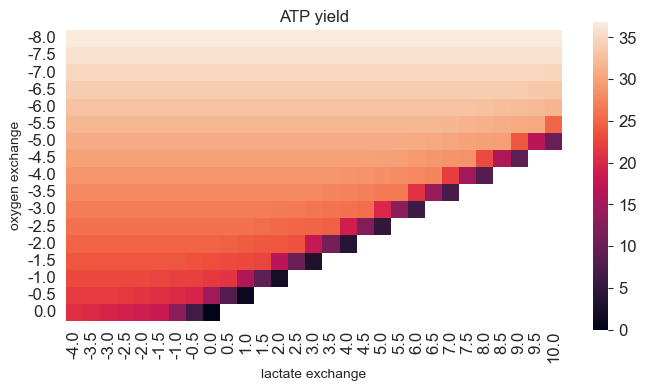

In [31]:
# heatmap
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(df_reshaped, annot=False, cmap='rocket', annot_kws={"size": 10})
plt.title('ATP yield')
plt.xlabel('lactate exchange')
plt.ylabel('oxygen exchange')
# make boxes square
plt.gca().set_aspect('equal', adjustable='box')
#  annotation font size
plt.tick_params(labelsize=12)
# size bar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# save figure in results folder
plt.savefig('results/ATP_yield_glucose4.18.png', dpi=300, bbox_inches='tight')


c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

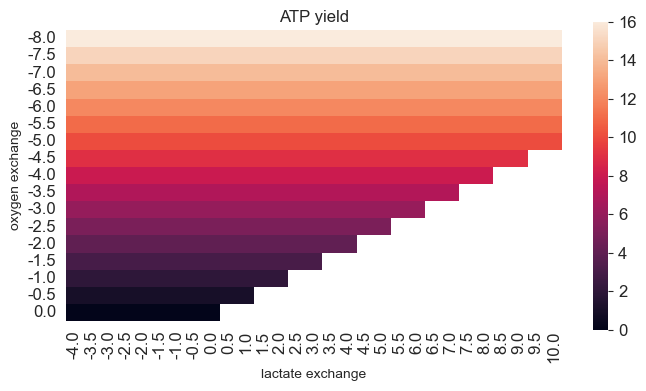

In [32]:
bounds_oxygen = create_stepwise_tuples(-8,1,0.5)
bounds_lactate = create_stepwise_tuples(-4,10,0.5)
ex_bounds = {'MAR09048':[(0,0)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(0,0)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

objective_values = []
fluxes = []
for i in range(len(bounds)):
    model = set_exchange_bounds(model,bounds[i])
    fba = model.optimize()
    fluxes.append(fba.fluxes)
    objective_values.append(fba.objective_value)

objective_values_df = pd.DataFrame(objective_values) # convert list to dataframe

# add labels
objective_values_df['labels'] = labels

b_df = pd.DataFrame()
# create list of b
for i in range(len(objective_values_df)):
    b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
    b_df = pd.concat([b_df,b],axis=0)

b_df.reset_index(inplace=True,drop=True) # reset index
pd.concat([b_df,objective_values_df],axis=1) # merge b_df and objective_values_df
objective_values_df.rename(columns={0:'objective_value'},inplace=True) # rename column 0 to 'objective_value'
df = pd.concat([b_df,objective_values_df],axis=1) # merge b_df and objective_values_df
df2 = df[['oxygen', 'lactate', 'objective_value']] # select columns for heathmap (oxygen, lactate, and objective_value)
df_reshaped = df2.pivot_table(index='oxygen', columns='lactate', values='objective_value') # reshape dataframe for heatmap

# heatmap
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(df_reshaped, annot=False, cmap='rocket', annot_kws={"size": 10})
plt.title('ATP yield')
plt.xlabel('lactate exchange')
plt.ylabel('oxygen exchange')
# make boxes square
plt.gca().set_aspect('equal', adjustable='box')
#  annotation font size
plt.tick_params(labelsize=12)
# size bar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# save figure in results folder
plt.savefig('results/ATP_yield_no_glucose.png', dpi=300, bbox_inches='tight')

In [33]:
# make fluxes df
fluxes_df = pd.DataFrame(fluxes)
fluxes_df = fluxes_df.reset_index().transpose()  # column names replace

In [34]:
model

Name,mod_RPE_PRrod_Lukowski_singleRPE
Memory address,256f208ec80
Number of metabolites,7186
Number of reactions,9831
Number of genes,2188
Number of groups,149
Objective expression,1.0*MAR03964_RPE - 1.0*MAR03964_RPE_reverse_dc7af
Compartments,"c_RPE, r_RPE, e_RPE, m_RPE, x_RPE, g_RPE, l_RPE, n_RPE, i_RPE, e_RPE_PR"


In [35]:
df2.transpose()

rxn_df = make_rxn_df(model)

# add df2.transpose() and fluxes_df.transpose() together horizontally
df3 = pd.concat([df2.transpose(), fluxes_df], axis=0)

# concat rxn_df and df3 vertically
df4 = pd.concat([df3,rxn_df], axis=1)

df4.to_clipboard()

In [36]:
# write df3 top excel in results folder/heatmaps folder
df3.to_excel('results/heatmaps/fluxes.xlsx')



c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest\lib\site-packages\cobra\u

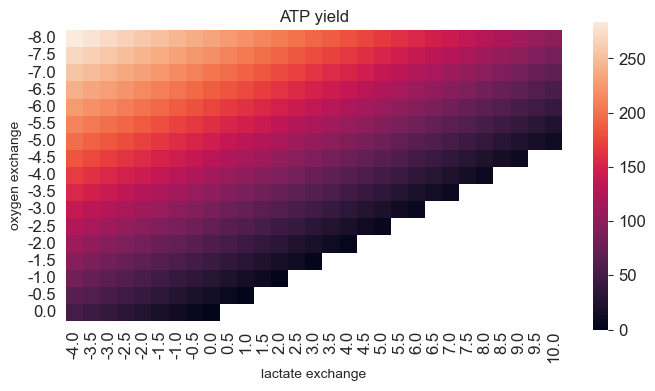

In [37]:
bounds_oxygen = create_stepwise_tuples(-8,1,0.5)
bounds_lactate = create_stepwise_tuples(-4,10,0.5)
ex_bounds = {'MAR09048':[(-1000,-1000)],\
        'MAR09034':bounds_oxygen,\
        'MAR09135':bounds_lactate}

ex_labels = {'glucose':[(-1000,-1000)],\
        'oxygen':bounds_oxygen,\
        'lactate':bounds_lactate}

bounds = create_permutation_dicts(ex_bounds)
labels = create_permutation_dicts(ex_labels)

objective_values = []
for i in range(len(bounds)):
    model = set_exchange_bounds(model,bounds[i])
    fba = model.optimize()
    objective_values.append(fba.objective_value)

objective_values_df = pd.DataFrame(objective_values) # convert list to dataframe

# add labels
objective_values_df['labels'] = labels

b_df = pd.DataFrame()
# create list of b
for i in range(len(objective_values_df)):
    b = pd.DataFrame(objective_values_df['labels'][i]).iloc[0].to_frame().T
    b_df = pd.concat([b_df,b],axis=0)

b_df.reset_index(inplace=True,drop=True) # reset index
pd.concat([b_df,objective_values_df],axis=1) # merge b_df and objective_values_df
objective_values_df.rename(columns={0:'objective_value'},inplace=True) # rename column 0 to 'objective_value'
df = pd.concat([b_df,objective_values_df],axis=1) # merge b_df and objective_values_df
df2 = df[['oxygen', 'lactate', 'objective_value']] # select columns for heathmap (oxygen, lactate, and objective_value)
df_reshaped = df2.pivot_table(index='oxygen', columns='lactate', values='objective_value') # reshape dataframe for heatmap

# heatmap
fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(df_reshaped, annot=False, cmap='rocket', annot_kws={"size": 10})
plt.title('ATP yield')
plt.xlabel('lactate exchange')
plt.ylabel('oxygen exchange')
# make boxes square
plt.gca().set_aspect('equal', adjustable='box')
#  annotation font size
plt.tick_params(labelsize=12)
# size bar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# save figure in results folder
plt.savefig('results/ATP_yield_glucose1000.png', dpi=300, bbox_inches='tight')



In [38]:
objective_values_df

,objective_value,labels
0,284.0,"{'glucose': (-1000, -1000), 'oxygen': (-8.0, -..."
1,277.5,"{'glucose': (-1000, -1000), 'oxygen': (-8.0, -..."
2,271.0,"{'glucose': (-1000, -1000), 'oxygen': (-8.0, -..."
3,264.5,"{'glucose': (-1000, -1000), 'oxygen': (-8.0, -..."
4,258.0,"{'glucose': (-1000, -1000), 'oxygen': (-8.0, -..."
...,...,...
546,NaN,"{'glucose': (-1000, -1000), 'oxygen': (1.0, 1...."
547,NaN,"{'glucose': (-1000, -1000), 'oxygen': (1.0, 1...."
548,NaN,"{'glucose': (-1000, -1000), 'oxygen': (1.0, 1...."
549,NaN,"{'glucose': (-1000, -1000), 'oxygen': (1.0, 1...."
